In [3]:
# Ensure all packages are installed
# %conda install -c conda-forge rasterio cartopy

In [2]:
# Imports for data segmentation and attribution
import numpy as np
import rasterio
from rasterio import features
from skimage.segmentation import slic, felzenszwalb, watershed, quickshift
from skimage.filters import sobel
from skimage.morphology import diamond, disk, rectangle, square, star, octagon
from skimage.filters.rank import modal
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from collections import OrderedDict
from geopandas import GeoDataFrame
from rasterstats import zonal_stats
from affine import Affine
import geopandas as gpd
import pandas as pd

In [5]:
# Imports for visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from rasterio.plot import show, show_hist
from skimage import img_as_float, exposure
import cartopy.crs as ccrs
from cartopy import config

# Imports for coordinate conversion...for cartopy
from pyproj import Transformer
utm2wgs = Transformer.from_crs(32632, 4326)

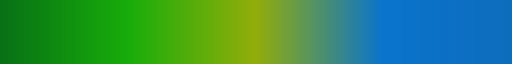

In [30]:
labels = ['forest', 'grassland-green', 'grassland-light', 'lake-deep', 'lake-sediment']
bounds = [1, 2, 3, 4, 5]
color_list = ['#087116', '#18ad0a', '#93ad0a', '#0a74cd', '#0e6dbd',]

def bin_mapping(x):
    for idx, bound in enumerate(bounds):
        if x < bound:
            return idx / (len(bounds) - 1.0)

bin_labels = [idx / (len(bounds) - 1.0) for idx in range(len(bounds))]

lc_cmap = LinearSegmentedColormap.from_list('mycmap', [(lbl, color) for lbl, color in zip(bin_labels, color_list)])

lc_cmap

In [4]:
# Imports for classification and accuracy assessment
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn import tree
from sklearn.metrics import accuracy_score

In [13]:
def bsq_to_bip(image):
    # no error checking yet...
    return  image.transpose(1, 2, 0)


def bip_to_bsq(image):
    # no error checking yet...
    return  image.transpose(2, 0, 1)

In [14]:
def vectorize(image=None, transform=None, crs=None):
    """
    Raster-to-Vector conversion.
    
    Performs a raster-to-vector conversion of a classified image. 
    
    Parameters
    ----------
    image: numpy.array
        A signle band of (classified, ideally) image data where the pixel
        values are integers. Shape is (1, rows, columns). This parameter is
        optional.
    
    transform: rasterio.transform
        A raster transform used to convert row/column values to geographic
        coordinates. This parameter is optional.

    crs: rasterio.crs
        A proj4 string representing the coordinate reference system. 
        This parameter is optional.
    
    Returns
    -------
    GeoDataFrame
        A vector version of the classified raster.
    """

    img = image[0].astype(np.int32)
        
    shps = features.shapes(img, transform=transform)
    records = []

    for id, shp in enumerate(shps):
        if shp[1] != 0:
            item = {'geometry': shp[0], 'id': id+1, 'properties': 
                    OrderedDict([('dn', np.int32(shp[1]))]),
                    'type': 'Feature'}
            records.append(item)

    vec = GeoDataFrame.from_features(records)
    vec.crs = crs
    return vec

In [15]:
def add_zonal_properties(image=None, transform=None,
                         band_names=['red','green','blue'], stats=['mean'],
                         gdf=None):
    """
    Adds zonal properties to a GeoDataFrame.
    
    Adds zonal properties to a GeoDataFrame, where the statistics 'stats' are
    calculated for all pixels within the geographic objects boundaries.
    
    Parameters
    ----------
    image: numpy.array
        A signle band of (classified, ideally) image data where the pixel
        values are integers. Shape is (1, rows, columns). This parameter is
        optional.
    
    transform: rasterio.transform
        A raster transform used to convert row/column values to geographic
        coordinates. This parameter is optional.
    
    band_names: list of strings
        The labels corresponding to each band of the src or image. 
    
    stats: list of strings
        The list of zonal statistics to calculate for each geographic object.
        The full list of stats is: ['sum', 'std', 'median', 'majority',
        'minority', 'unique', 'range', 'nodata', 'percentile_<q>']. Replace
        <q> with a value between 1 and 100, inclusive.
    
    gdf: GeoDataFrame
        The GeoDataFrame to be updated with zonal statistics. The number of
        columns that will be added is equal to len(bands) * len(stats). 
    
    Returns
    -------
    GeoDataFrame
        A GeoDataFrame with the zonal statistics added as new columns. 
    """
    if len(image.shape) > 2:
      if len(image) != len(band_names): 
          print("The number of bands must equal the number of bands_names.")
          return None
    else:
      if len(band_names) != 1:
        print("You do not have the correct number of band_names.")
        return None

    if len(image.shape) > 2:
        for band, name in enumerate(band_names):
            raster_stats = zonal_stats(gdf, image[band], stats=stats,
                                       nodata=np.nan, affine=transform)
          
            fields = [[] for i in range(len(stats))]
            labels = []

            for i, rs in enumerate(raster_stats):
                for j, r in enumerate(rs):
                    if i == 0:
                        labels.append(r)
                    fields[j].append(rs[r])

            for i, l in enumerate(labels):
                gdf.insert(len(gdf.columns)-1, name + "_" + l, fields[i])
    else:
        raster_stats = zonal_stats(gdf, image, stats=stats,
                                   nodata=np.nan, affine=transform)

        fields = [[] for i in range(len(stats))]
        labels = []
      
        for i, rs in enumerate(raster_stats):
            for j, r in enumerate(rs):
                if i == 0:
                    labels.append(r)
                fields[j].append(rs[r])
      
        for i, l in enumerate(labels):
            gdf.insert(len(gdf.columns)-1, band_names[0] + "_" + l, fields[i])

    return gdf

In [16]:
def get_prop(props, label):
    for p in props:
        if p.label == label:
            return p

In [17]:
def add_shape_properties(classified_image, gdf, attributes=['area', 'perimeter']):
    """
    Add raster properties as vector fields.
    
    POSSIBLE IMPROVEMENT!! REMOVE PARAMETER classified_image AND INSTEAD USE 
    rasterize TO RASTERIZE THE gdf. 
        
    Parameters
    ----------
    classified_image: numpy.array
        A 2D image with integer, class-based, values.
    
    gdf: GeoDataFrame
        A GeoDataFrame (vector) with object boundaries corresponding to image
        regions. Image attributes will be assigned to each vector object.
    
    attributes: list of strings
        attributes is a list of strings where each string is a type of shape to
        calculate for each polygon. Possible shapes include: area, bbox_area,
        centroid, convex_area, eccentricity, equivalent_diamter, euler_number,
        extent, filled_area, label, maxor_axis_length, max_intensity,
        mean_intensity, min_intensity, minor_axis_length, orientation,
        perimeter, or solidity.
    
    Returns
    -------
    Nothing
        Instead modifies GeoDataFrame in place.
    """
    clim = classified_image[0, :, :]
    props = regionprops(clim)
    
    attributes = {s: [] for s in attributes}

    for row in gdf.itertuples():
        rid = getattr(row, 'dn')
        
        p = get_prop(props, rid)
        if p is not None:
            for a in attributes:
                attributes[a].append(getattr(p, a))

    try:
        for a in attributes:
            if (a == 'area'):
                gdf.insert(len(gdf.columns)-1, a, gdf.geometry.area)
            elif (a == 'perimeter'):
                gdf.insert(len(gdf.columns)-1, a, gdf.geometry.length)
            else:
                gdf.insert(len(gdf.columns)-1, a, attributes[a])
    except:
        print("The geometry is bad for this gdf.")
        print(gdf.columns)
    
    return gdf

In [18]:
def sobel_edge_detect(image=None, mask=None):
    """
    Performs a Sobel edge detection.

    Performs a Sobel edge detection on a 2D image.
    
    Parameters
    ----------
    image: numpy.array
        A rasterio-style image. The image is any single band obtained by: 
            image = src.read(band, masked=True), where band is an integer.
        This parameter is optional.
            
    mask: numpy.array
        A rasterio-style image. The image is any single band obtained by: 
            image = src.read_masks(1), where band is an integer. 
        This parameter is optional.
        
    Returns
    -------
    numpy.array
        A single band, rasterio-style image ([band][row][column]).
    """
    # image = image
    # mask[mask > 255] = 1
        
    edges = sobel(image)
    return bip_to_bsq(edges[:, :, np.newaxis])

In [7]:
def segmentation(image=None, mask=None, model=None, params=None,
                 modal_footprint=np.zeros(1), sieve_size=None):
    
# modal_radius=None, # old parameter...delete when known not needed
    """
    Segment the image.

    Segment the image using an algorithm from sklearn.segmentation.

    Parameters
    ----------
    model: skimage.segmentation model
        A model from skimage.segmentation (e.g., slic, slic0, felzenswalb)

    params: sklearn.segmentation model parameters
        The unique parameters for the selected segmentation algorithm. Will be
        passed to the model as the kwargs argument.
        
    image: numpy.array
        A 3-band (RGB) image used for segmentation. The shape of the image
        must be ordered as follows: (bands, rows, columns).
        This parameter is optional.
    
    mask: numpy.array
        A 1-band image mask. The shape of the mask must be ordered as follows:
        (rows, columns). This parameter is optional.
    
    modal_radius: integer
        Integer representing the radius of a raster disk (i.e., circular
        roving window). Optional. If not set, no modal filter will be applied.
        
    modal_footprint: skimage.morphology 2D shape
        A diamond, disk, rectangle, square, or octagon function that returns
        a kernel shaped according to the specific function
    
    sieve_size: integer
        An integer representing the smallest number of pixels that will be
        included as a unique segment. Segments this size or smaller will be
        merged with the neighboring segment with the most pixels. Optional. 
        If not set, no modal filter will be applied.

    Returns
    -------
    numpy.array
        A numpy array arranged as rasterio would read it (bands=1, rows, cols)
        so it's ready to be written by rasterio

    """
    if model.__name__ == 'watershed':
      if len(image.shape) > 2:
        print(f"Image has too many dimensions for watershed segmentation.")
        print("This will cause errors. Create a grayscale image before preceeding. Exiting.")
        return
      else:
        img = image
    else:
        img = bsq_to_bip(image)

    output = model(img, **params).astype('int32')

    while np.ndarray.min(output) < 1:
        output += 1

    # if modal_radius != None:
    #     output = modal(output.astype('int16'), footprint=disk(modal_radius))
        
    if modal_footprint.any():
        output = modal(output.astype('int16'), footprint=modal_footprint)

    if sieve_size != None:
        output = features.sieve(output, sieve_size)
    
    output = bip_to_bsq(output[:, :, np.newaxis])

    return output

In [3]:
def rgb_composite(image, red_band, green_band, blue_band):
    my_red = image[red_band]
    my_green = image[green_band]
    my_blue = image[blue_band]
    return np.stack([my_red, my_green, my_blue])